In [1]:
import pandas as pd
import plotly.graph_objects as go
from collections import deque
from IPython.display import display, HTML

In [2]:
trades_wn_dn1 = pd.read_csv('trades_round_1_day_-1_wn.csv', delimiter=';')
trades_wn_dn2 = pd.read_csv('trades_round_1_day_-2_wn.csv', delimiter=';')
trades_wn_d0 = pd.read_csv('trades_round_1_day_0_wn.csv', delimiter=';')

trades_r3_d0 = pd.read_csv('trades_round_3_day_0_wn.csv', delimiter=';')
trades_r3_d1 = pd.read_csv('trades_round_3_day_1_wn.csv', delimiter=';')
trades_r3_d2 = pd.read_csv('trades_round_3_day_2_wn.csv', delimiter=';')

trades_r4_d1 = pd.read_csv('trades_round_4_day_1_wn.csv', delimiter=';')
trades_r4_d2 = pd.read_csv('trades_round_4_day_2_wn.csv', delimiter=';')
trades_r4_d3 = pd.read_csv('trades_round_4_day_3_wn.csv', delimiter=';')

In [3]:
prices_r1_dn1 = pd.read_csv('prices_round_1_day_-1.csv', delimiter=';')
prices_r1_dn2 = pd.read_csv('prices_round_1_day_-2.csv', delimiter=';')
prices_r1_d0 = pd.read_csv('prices_round_1_day_0.csv', delimiter=';')

prices_r3_d0 = pd.read_csv('prices_round_3_day_0.csv', delimiter=';')
prices_r3_d1 = pd.read_csv('prices_round_3_day_1.csv', delimiter=';')
prices_r3_d2 = pd.read_csv('prices_round_3_day_2.csv', delimiter=';')

prices_r4_d1 = pd.read_csv('prices_round_4_day_1.csv', delimiter=';')
prices_r4_d2 = pd.read_csv('prices_round_4_day_2.csv', delimiter=';')
prices_r4_d3 = pd.read_csv('prices_round_4_day_3.csv', delimiter=';')

In [4]:
prices_r1_d0

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,AMETHYSTS,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
1,0,0,STARFRUIT,5036,30,NaN,NaN,NaN,NaN,5043,30,NaN,NaN,NaN,NaN,5039.5,0.0
2,0,100,AMETHYSTS,9996,1,9995.0,30.0,NaN,NaN,10002,6,10004.0,1.0,10005.0,30.0,9999.0,0.0
3,0,100,STARFRUIT,5041,4,5037.0,1.0,5036.0,30.0,5043,31,NaN,NaN,NaN,NaN,5042.0,0.0
4,0,200,AMETHYSTS,9996,1,9995.0,21.0,NaN,NaN,10004,1,10005.0,21.0,NaN,NaN,10000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0
19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0
19997,0,999800,AMETHYSTS,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0


In [64]:
def plot_trades(df_trades, df_prices, trader_name, product_name, counterparty, size_threshold):
    # Filter trades for specific interactions with the counterparty and size
    buys = df_trades[(df_trades['buyer'] == trader_name) & (df_trades['seller'] == counterparty) & (df_trades['symbol'] == product_name) & (df_trades['quantity'] >= size_threshold)]
    sells = df_trades[(df_trades['seller'] == trader_name) & (df_trades['buyer'] == counterparty) & (df_trades['symbol'] == product_name) & (df_trades['quantity'] >= size_threshold)]
    
    # Filter price data for the specific product
    mid_prices = df_prices[df_prices['product'] == product_name]

    # Creating the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=buys['timestamp'], y=buys['price'], mode='markers', name='Buys', marker=dict(color='green', size=10, opacity=0.5))) # buys['quantity']**2/8
    fig.add_trace(go.Scatter(x=sells['timestamp'], y=sells['price'], mode='markers', name='Sells', marker=dict(color='red', size=10, opacity=0.5))) # sells['quantity']**2/8
    if not mid_prices.empty:
        fig.add_trace(go.Scatter(x=mid_prices['timestamp'], y=mid_prices['mid_price'], mode='lines', name='Mid Price', line=dict(color='blue', width=2)))

    fig.update_layout(title=f'Trades for {trader_name} with {counterparty} on {product_name} (size >= {size_threshold})',
                      xaxis_title='Timestamp',
                      yaxis_title='Price',
                      legend_title='Transaction Type')
    fig.show()

In [65]:
def plot_realized_pl(df, trader_name, product_name):
    buys = df[(df['buyer'] == trader_name) & (df['symbol'] == product_name)].copy()
    buys['type'] = 'buy'
    buys['quantity'] = buys['quantity']
    
    sells = df[(df['seller'] == trader_name) & (df['symbol'] == product_name)].copy()
    sells['type'] = 'sell'
    sells['quantity'] = -sells['quantity']  # Treat sells as negative for uniform handling
    
    transactions = pd.concat([buys, sells])
    transactions.sort_values('timestamp', inplace=True)

    positions = deque()
    realized_pl = []
    pl_total = 0

    for _, transaction in transactions.iterrows():
        transaction_quantity = transaction['quantity']
        transaction_price = transaction['price']
        transaction_timestamp = transaction['timestamp']

        while transaction_quantity != 0:
            if not positions:
                positions.append({'quantity': transaction_quantity, 'price': transaction_price})
                break

            position = positions[0]
            if (position['quantity'] > 0 and transaction_quantity < 0) or (position['quantity'] < 0 and transaction_quantity > 0):
                quantity_to_close = min(abs(transaction_quantity), abs(position['quantity']))
                pl = quantity_to_close * (abs(transaction_price) - abs(position['price']))
                if position['quantity'] < 0:
                    pl = -pl

                pl_total += pl
                realized_pl.append({'timestamp': transaction_timestamp, 'P&L': pl_total})

                position['quantity'] += transaction_quantity
                if position['quantity'] == 0:
                    positions.popleft()  # Remove closed position
                transaction_quantity += quantity_to_close if transaction_quantity < 0 else -quantity_to_close
            else:
                positions.append({'quantity': transaction_quantity, 'price': transaction_price})
                break

    pl_df = pd.DataFrame(realized_pl)
    if not pl_df.empty:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=pl_df['timestamp'], y=pl_df['P&L'], mode='lines+markers', name='Realized P&L'))
        fig.update_layout(title=f'Realized P&L for {trader_name} on {product_name}',
                          xaxis_title='Timestamp',
                          yaxis_title='Profit and Loss',
                          legend_title='P&L')
        fig.show()
    else:
        print("No completed transactions to calculate realized P&L.")


In [66]:
def analyze_trades(df_trades, df_prices, size_threshold):
    def get_unique_symbols(df):
        return df['symbol'].unique()
    
    def get_unique_traders(df):
        buyers = df['buyer'].unique()
        sellers = df['seller'].unique()
        return set(buyers).union(set(sellers))
    
    def get_buys(df, trader_name):
        return df[df['buyer'] == trader_name]

    def get_sells(df, trader_name):
        return df[df['seller'] == trader_name]

    unique_traders = get_unique_traders(df_trades)
    unique_symbols = get_unique_symbols(df_trades)

    for trader in unique_traders:
        for symbol in unique_symbols:
            buys = get_buys(df_trades, trader)
            sells = get_sells(df_trades, trader)

            buys = buys[buys['symbol'] == symbol]
            sells = sells[sells['symbol'] == symbol]

            # Collecting unique counterparties from buys and sells
            counterparties = set(buys['seller'].unique()).union(set(sells['buyer'].unique()))

            if counterparties:
                for counterparty in counterparties:
                    print(f"\nTrader: {trader}, Product: {symbol}, Counterparty: {counterparty}")
                    plot_trades(df_trades, df_prices, trader, symbol, counterparty, size_threshold)
            else:
                print("No specific counterparties or substantial trades found for transactions.")



In [8]:
# copypaste into the cell below to see 1 at a time
"""
analyze_trades(trades_wn_dn2, prices_r1_dn2, size_threshold=10)
analyze_trades(trades_wn_dn1, prices_r1_dn1, size_threshold=10)
analyze_trades(trades_wn_d0, prices_r1_d0, size_threshold=10)

analyze_trades(trades_r3_d0, prices_r3_d0, size_threshold=10)
analyze_trades(trades_r3_d1, prices_r3_d1, size_threshold=10)
analyze_trades(trades_r3_d2, prices_r3_d2, size_threshold=10)

analyze_trades(trades_r4_d1, prices_r4_d1, size_threshold=10)
analyze_trades(trades_r4_d2, prices_r4_d2, size_threshold=10)
analyze_trades(trades_r4_d3, prices_r4_d3, size_threshold=10)
"""

'\nanalyze_trades(trades_wn_dn2, prices_r1_dn2, size_threshold=10)\nanalyze_trades(trades_wn_dn1, prices_r1_dn1, size_threshold=10)\nanalyze_trades(trades_wn_d0, prices_r1_d0, size_threshold=10)\n\nanalyze_trades(trades_r3_d0, prices_r3_d0, size_threshold=10)\nanalyze_trades(trades_r3_d1, prices_r3_d1, size_threshold=10)\nanalyze_trades(trades_r3_d2, prices_r3_d2, size_threshold=10)\n\nanalyze_trades(trades_r4_d1, prices_r4_d1, size_threshold=10)\nanalyze_trades(trades_r4_d2, prices_r4_d2, size_threshold=10)\nanalyze_trades(trades_r4_d3, prices_r4_d3, size_threshold=10)\n'

In [92]:
size_threshold = 8
prod_list = ['STRAWBERRIES', 'CHOCOLATES']


Trader: Remy, Product: STRAWBERRIES, Counterparty: Vladimir


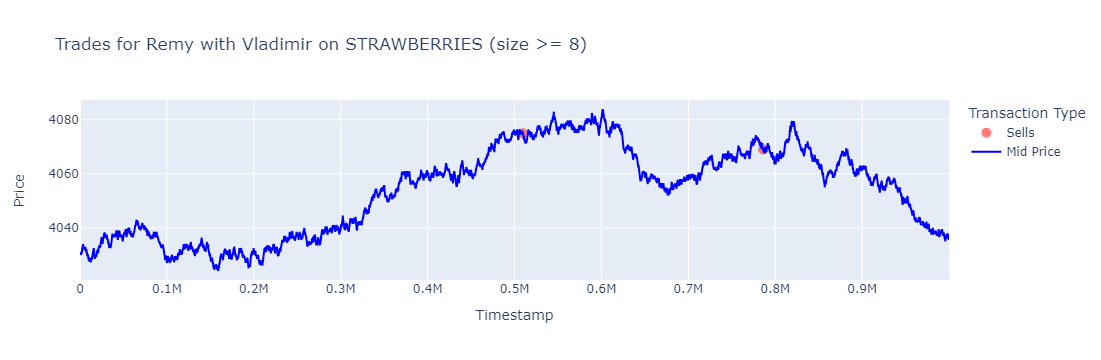


Trader: Remy, Product: STRAWBERRIES, Counterparty: Vinnie


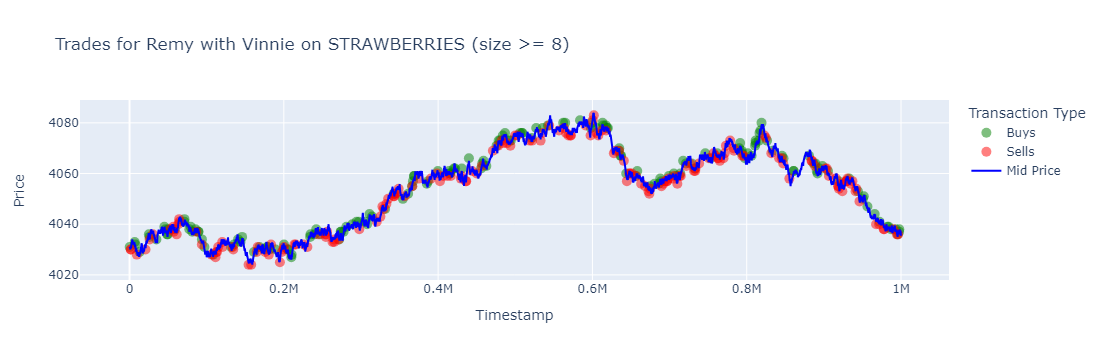


Trader: Vladimir, Product: STRAWBERRIES, Counterparty: Remy


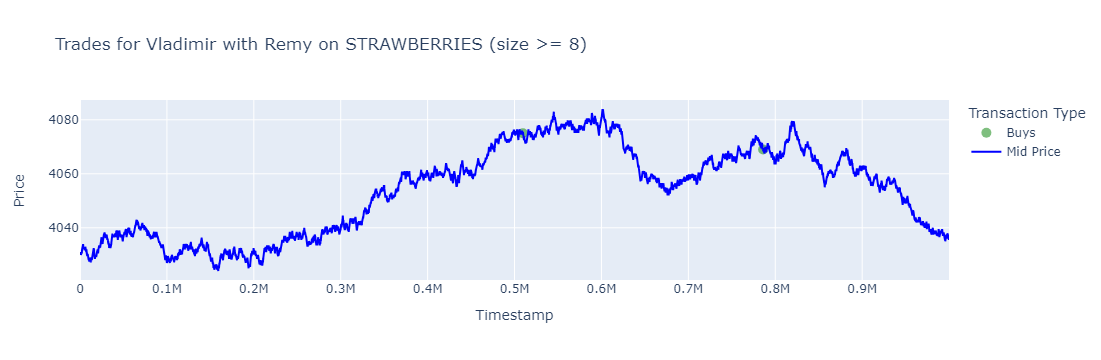


Trader: Vladimir, Product: STRAWBERRIES, Counterparty: Vinnie


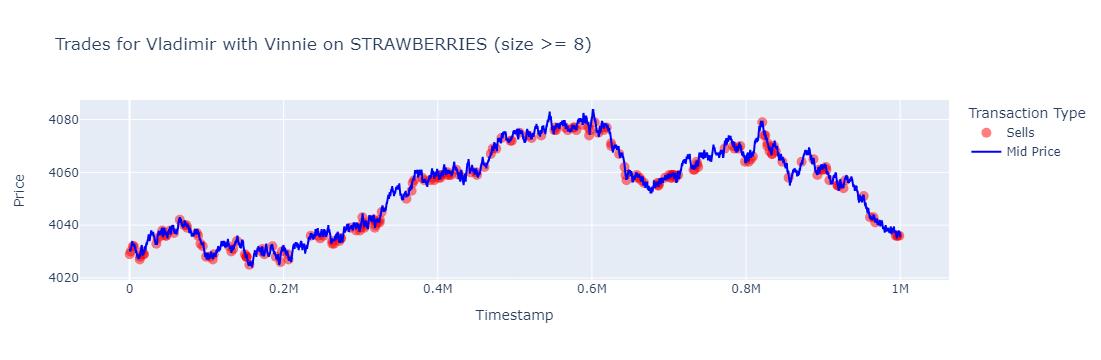


Trader: Vinnie, Product: STRAWBERRIES, Counterparty: Remy


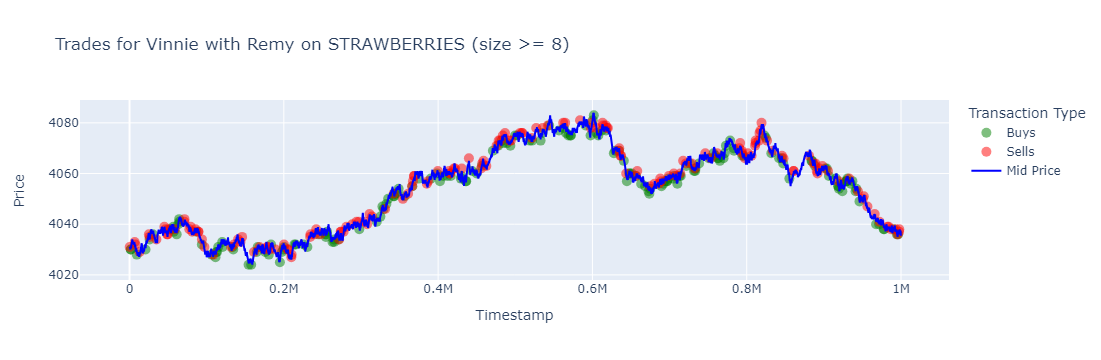


Trader: Vinnie, Product: STRAWBERRIES, Counterparty: Vladimir


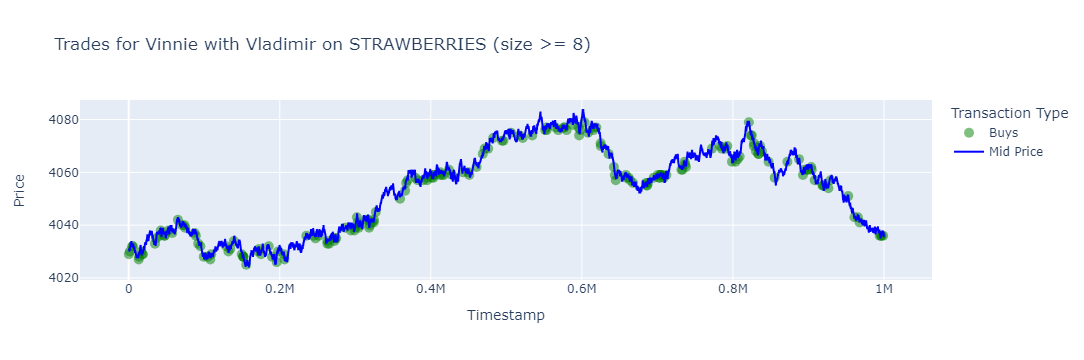

In [93]:
analyze_trades(trades_r3_d1[trades_r3_d1['symbol'].isin(prod_list)], prices_r3_d1[prices_r3_d1['product'].isin(prod_list)], size_threshold)